### Distance distribution from variant to tss


the idea is that the pcqtls are maybe picking up on more distant signals/regulatory elements?


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000
#mpl.rcParams['figure.dpi']= 100


In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/new_clusters/proteincoding_rewrite.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
overlap_output_dir = config['overlap_output_dir']
pc_output_dir = config['pc_output_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

In [4]:
# load in the data from all tissues
overlap_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_dfs.append(pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t'))
overlap_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(overlap_dfs, tissue_ids)])
overlap_df.reset_index(inplace=True, drop=True)


# for debugging, try with a single tissue 
#overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')

In [5]:
# add pc 1 and 2 specific columns
def count_pc(id_list, pc_num):
    return sum([f'pc{pc_num}' in phenotype_id for phenotype_id in id_list])

overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)

# add in general pc id column
overlap_df['pc_num'] = np.where(overlap_df['orig_cs_dataset']=='pc_qtl',  overlap_df['cs_full_id'].str.split('_').str[-2].str.strip('pc'), 0)
overlap_df['pc_num'] = overlap_df['pc_num'].astype(int)
# add in cluster size
overlap_df['cluster_size'] = overlap_df['cluster_id'].str.split('_').apply(len)

# add in the variant position as a column
overlap_df['lead_variant_pos'] = overlap_df['lead_variant_id'].str.split('_').str[1].astype(int)

# TSS distance

In [6]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

# add in the start and end info
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])
full_gencode['gene_end'] = np.where(full_gencode['strand'] == '-', full_gencode['start'], full_gencode['end'])

# filter to just the transcripts that are in the clusters
gene_ids = np.concatenate(overlap_df['cluster_id'].str.split('_'))
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()

In [7]:
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    starts = cluster_gene_df['tss_start'].values
    distances = row['lead_variant_pos'] - starts
    # return smallest absolute value distance
    idx = np.argmin(abs(distances))
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
# for just the egenes, get the egene start that actually matched the gene of interest
def get_egene_distance(row):
    assert row['orig_cs_dataset'] =='control_eqtl'
    egene = row['cs_full_id'].split('_e_')[1]
    gene_df = gid_gencode.loc[egene]
    #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -(row['lead_variant_pos']-gene_df.tss_start)
    else:
        return row['lead_variant_pos']-gene_df.tss_start

In [8]:
# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
overlap_df['cluster_min_distance'] = overlap_df.progress_apply(get_tss, axis=1)

# optionally, write out with distances 
#overlap_df.to_csv(f'{prefix}/{overlap_output_dir}/all.overlap.distances.txt', sep='\t')

  0%|          | 0/41244 [00:00<?, ?it/s]

In [9]:
# annotate all eqtls with the distance to their egene
e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']
e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)

  0%|          | 0/20991 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.43033283/ipykernel_45634/3634702297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)


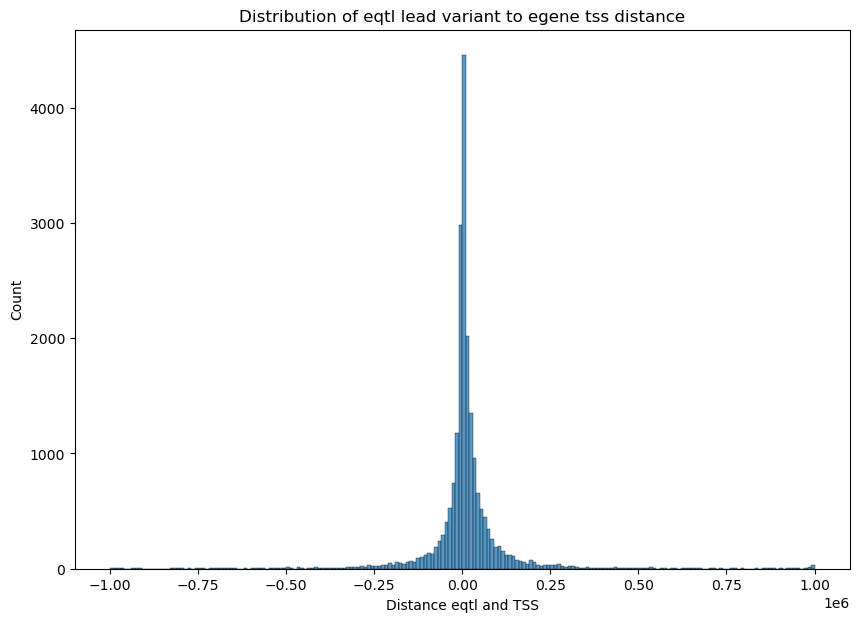

In [10]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))
# you can ocasionally get variants further than this due to large cluster sizes
# clipped for clarity 
sns.histplot(e_overlap_df['egene_distance'].clip(-1000000, 1000000), bins=200, ax=ax)
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of eqtl lead variant to egene tss distance')
plt.show()

In [11]:
# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], 
                                                 e_overlap_df['egene_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], 
                                        pd.Series(['eqtl_egene']*len(e_overlap_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_closest_cluster_gene'

# plotable distances 
joined['clip_distance'] = joined['distance'].clip(-1000000, 1000000)
joined['abs_clip_distance_kb'] = joined['clip_distance'].apply(abs) /1000

Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

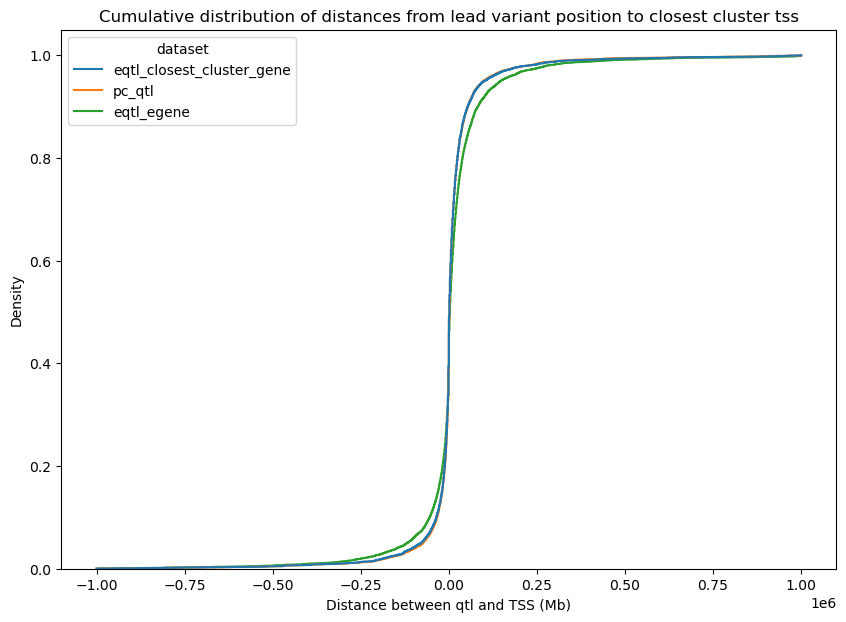

In [12]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='clip_distance', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (Mb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')


Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

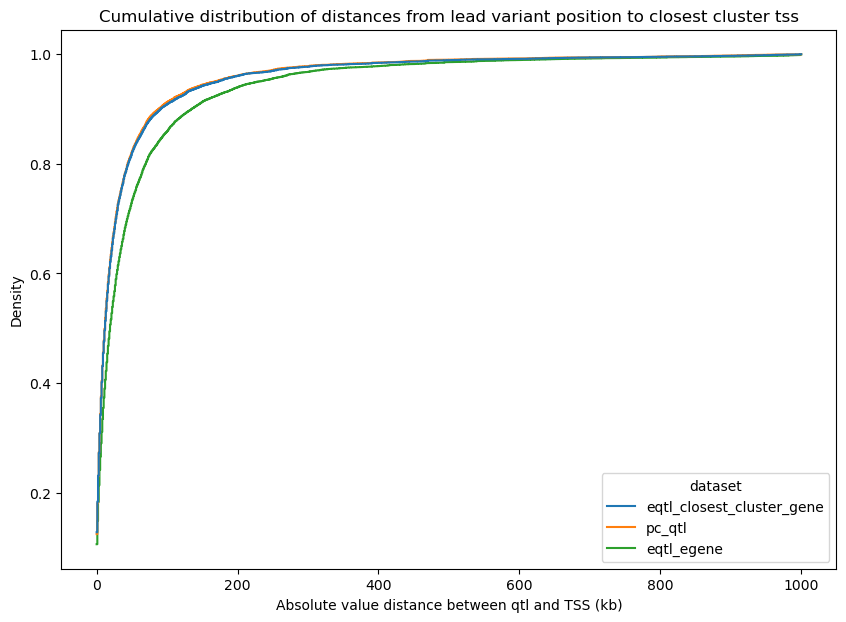

In [13]:
# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='abs_clip_distance_kb', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000)
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')

# broken up by pc number

In [14]:
# plotable distance for overlap df

overlap_df['clip_distance'] = overlap_df['cluster_min_distance'].clip(-1000000, 1000000)
overlap_df['abs_clip_distance_kb'] = overlap_df['clip_distance'].apply(abs)/1000


e_overlap_df['clip_egene_distance'] = e_overlap_df['egene_distance'].clip(-1000000, 1000000)
e_overlap_df['abs_clip_egene_distance_kb'] = e_overlap_df['clip_egene_distance'].apply(abs)/1000

overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,5)

/local/scratch/klawren/slrmtmp.43033283/ipykernel_45634/1146841988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['clip_egene_distance'] = e_overlap_df['egene_distance'].clip(-1000000, 1000000)
/local/scratch/klawren/slrmtmp.43033283/ipykernel_45634/1146841988.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['abs_clip_egene_distance_kb'] = e_overlap_df['clip_egene_distance'].apply(abs)/1000


([<matplotlib.lines.Line2D object at 0x2b6ccbac3fa0>, <matplotlib.lines.Line2D object at 0x2b6ccf19f4c0>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Cumulative distance distribution lead variant position to closest cluster tss by pc number')

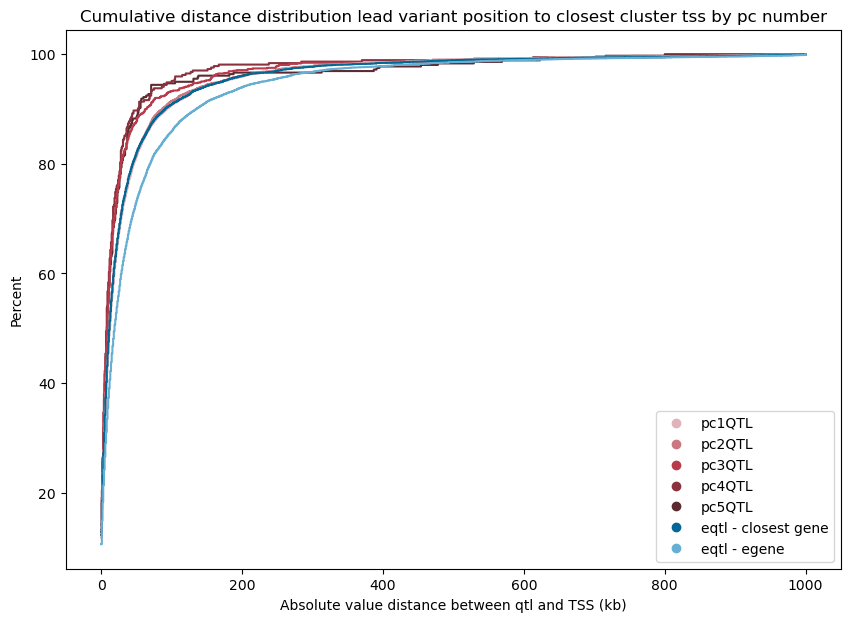

In [15]:
# clip the number of pcs
max_pcs = 5
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
# palette 
root_color = '#B83A4B'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark

# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df, x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cumulative distance distribution lead variant position to closest cluster tss by pc number')


([<matplotlib.lines.Line2D object at 0x2b6ccc23fee0>, <matplotlib.lines.Line2D object at 0x2b6ccd73b370>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Exclusive pcQTLs: cumulative distance distribution lead variant position to closest cluster tss')

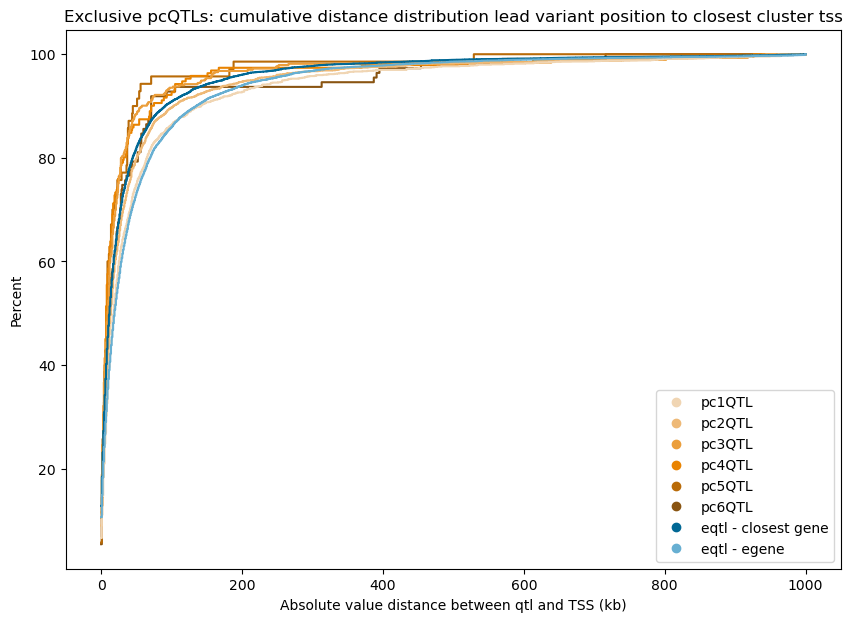

In [16]:

# clip the number of pcs
max_pcs = 6
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[overlap_df['num_e_overlap']==0], x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Exclusive pcQTLs: cumulative distance distribution lead variant position to closest cluster tss')


([<matplotlib.lines.Line2D object at 0x2b6ccac84100>, <matplotlib.lines.Line2D object at 0x2b6cc54163d0>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Cluster > 2, exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')

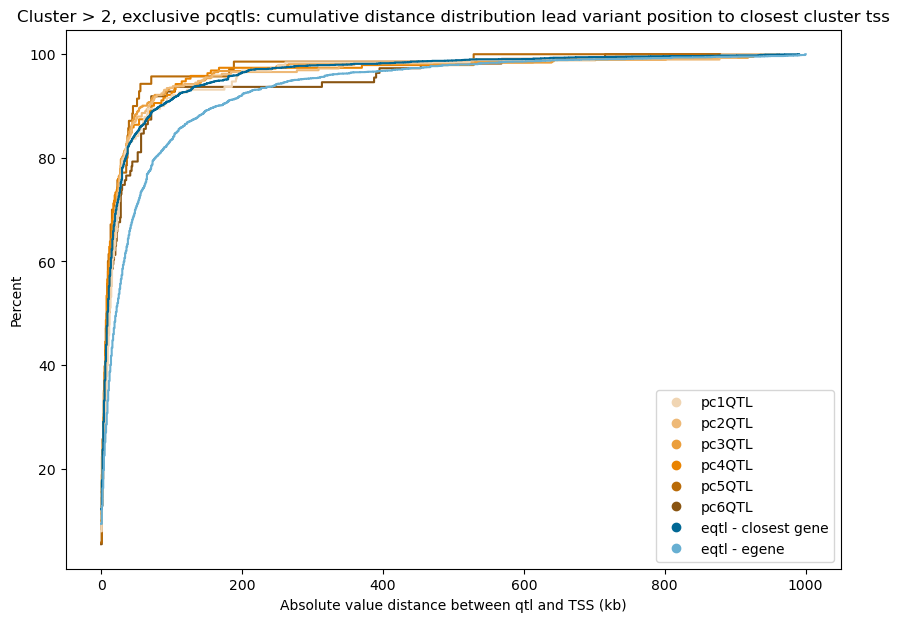

In [18]:

# larger clusters?
max_pcs = 6
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[(overlap_df['cluster_size']>2) & (overlap_df['num_e_overlap']==0)], x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[(overlap_df['cluster_size']>2) & (overlap_df['orig_cs_dataset']=='control_eqtl')], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df[(e_overlap_df['cluster_size']>2)], x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cluster > 2, exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')


([<matplotlib.lines.Line2D object at 0x2b6cd18036d0>, <matplotlib.lines.Line2D object at 0x2b6cd181a940>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')

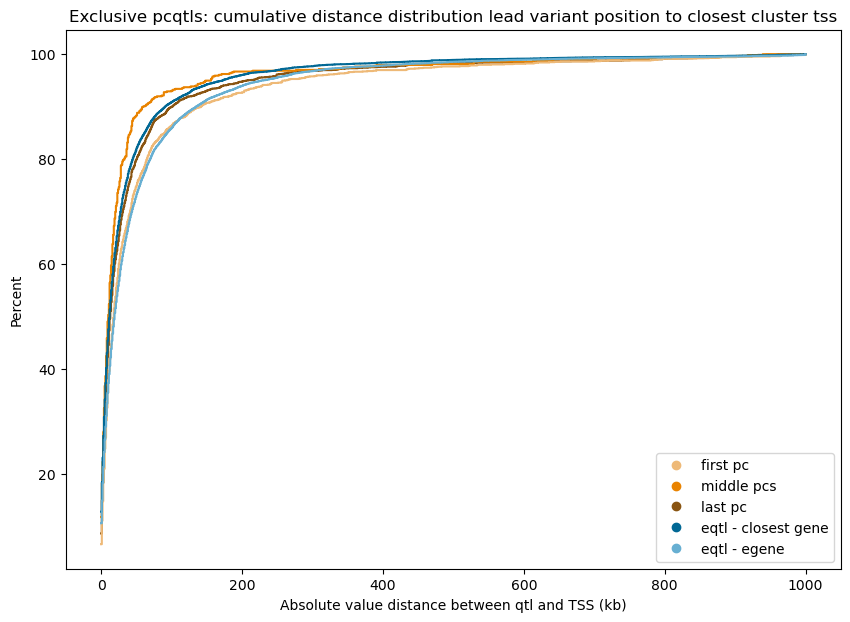

In [21]:
# split first, last, and middle pcs

overlap_df['pc_order'] = 'middle'
overlap_df.loc[overlap_df['pc_num'] == overlap_df['cluster_size'],'pc_order'] = 'last'
overlap_df.loc[overlap_df['pc_num'] == 1,'pc_order'] = 'first'


# absolute value of distance plot for pc seperated be first middle and last
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
max_pcs=3
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[(overlap_df['num_e_overlap']==0)], x='abs_clip_distance_kb', hue='pc_order', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:3], hue_order=['first', 'middle', 'last'])


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[(overlap_df['orig_cs_dataset']=='control_eqtl')], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=['first pc', 'middle pcs', 'last pc', 'eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')



## for the poster

In [22]:
# add in data for exclusively pc variants
exclusivepc_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]


# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], 
                                                 e_overlap_df['egene_distance'], 
                                                 exclusivepc_df['cluster_min_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], 
                                        pd.Series(['eqtl_egene_only']*len(e_overlap_df)), 
                                        pd.Series(['exclusive_pcqtl']*len(exclusivepc_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'
joined['abs_distance'] = joined['distance'].apply(abs)

# filter to just the categories for the poster
joined = joined[joined['dataset'].isin(['eqtl_all_cluster_genes', 'eqtl_egene_only' , 'pc_qtl', 'exclusive_pcqtl' ])]

/local/scratch/klawren/slrmtmp.43033283/ipykernel_45634/3159881205.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(h,


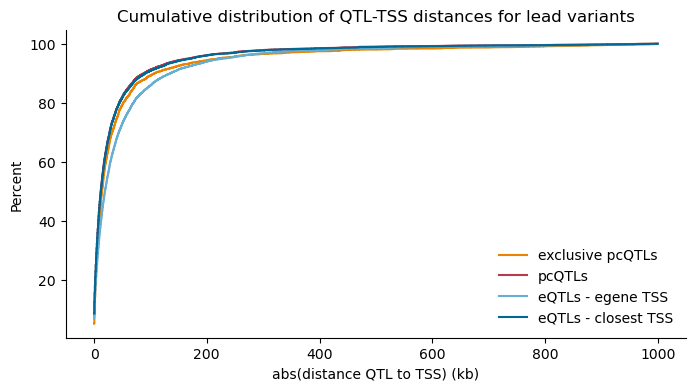

In [23]:
# absolute value of distance for that plot
joined['clip_distance'] = joined['distance'].clip(-1000000, 1000000)
joined['abs_clip_distance_kb'] = joined['clip_distance'].apply(abs) /1000
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=joined, x='abs_clip_distance_kb', hue='dataset', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, palette={'eqtl_all_cluster_genes':'#016895', 'pc_qtl':'#B83A4B', 'exclusive_pcqtl':'#E98300', 'eqtl_egene_only':'#67AFD2'},
            hue_order = ['eqtl_all_cluster_genes', 'eqtl_egene_only' , 'pc_qtl', 'exclusive_pcqtl'], 
            bins=2000)
plt.xlabel('abs(distance QTL to TSS) (kb)')
plt.title('Cumulative distribution of QTL-TSS distances for lead variants')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

h, l = ax.get_legend_handles_labels()
ax.legend(h, 
          labels=[ 'exclusive pcQTLs', 'pcQTLs', 'eQTLs - egene TSS',  'eQTLs - closest TSS'], frameon=False)


plt.show()


# Old

the distance from the qtl to just the relevant egene is defiently furhter than the closest in the cluster appraoich, as would sort of be expected

In [40]:
# are there more before or after a certain cutoff?
overlap_df['abs_distance'] = overlap_df['cluster_min_distance'].apply(abs)

print('Median: {} bp'.format(overlap_df['abs_distance'].median()))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} median: {} bp'.format(dataset, overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'].median()))
print('\t {} mean: {:.1f} bp'.format('exclusively_pcqtl', overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]['abs_distance'].median()))


print('Mean: {:.1f} bp'.format(overlap_df['abs_distance'].mean()))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} mean: {:.1f} bp'.format(dataset, overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'].mean()))
print('\t {} mean: {:.1f} bp'.format('exclusively_pcqtl', overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]['abs_distance'].mean()))

print('> 100 kb: {:.2f} % lead variants'.format(sum(overlap_df['abs_distance'] > 100000)/len(overlap_df)*100))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} > 100 kb: {:.2f} % lead variants'.format(dataset, sum(overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'] > 100000)/sum(overlap_df['orig_cs_dataset']==dataset)*100))
print('\t {} mean: {:.1f} % lead variants'.format('exclusively_pcqtl', (sum(overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]['abs_distance'] > 100000)/len(exclusivepc_df)*100)))


Median: 15273.5 bp
	 control_eqtl median: 14696.0 bp
	 pc_qtl median: 15940.0 bp
	 exclusively_pcqtl mean: 21931.0 bp
Mean: 56344.0 bp
	 control_eqtl mean: 47164.9 bp
	 pc_qtl mean: 65766.4 bp
	 exclusively_pcqtl mean: 87974.4 bp
> 100 kb: 12.60 % lead variants
	 control_eqtl > 100 kb: 11.24 % lead variants
	 pc_qtl > 100 kb: 13.99 % lead variants
	 exclusively_pcqtl mean: 17.2 % lead variants


>10 % variance explained (from pcqtls/workflow/notebooks/pc_gene_variance.ipynb)

In [53]:
## try with a list of pcs that explain more than 10% of the variance from at least  two genes in the cluster
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

pcs_variances = pd.read_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.variances.csv', sep='\t', index_col=0)


In [100]:
pc_ids_10 = pcs_variances[(pcs_variances['second_largest_variance']>70)]['gene_id']
pc_ids_20 = pcs_variances[(pcs_variances['second_largest_variance']>10)]['gene_id']
pc_ids_30 = pcs_variances[(pcs_variances['second_largest_variance']>10)]['gene_id']

overlap_df['phenotype_id'] = overlap_df['cs_full_id'].str.split('_cs').str[0]

In [101]:
# add in data for exclusively pc variants
pc_10_df_exclusive = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['phenotype_id'].isin(pc_ids_10))]
pc_10_df = overlap_df[(overlap_df['phenotype_id'].isin(pc_ids_10))]
single_egene = overlap_df[(overlap_df['num_e_overlap']==1)]
multi_egene = overlap_df[(overlap_df['num_e_overlap']>1)]

In [102]:
# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], 
                                                 pc_10_df_exclusive['cluster_min_distance'], 
                                                 pc_10_df['cluster_min_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], 
                                        pd.Series(['pc_10_df_exclusive']*len(pc_10_df_exclusive)), 
                                        pd.Series(['pc_10_df']*len(pc_10_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'
joined['abs_distance'] = joined['distance'].apply(abs)

Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

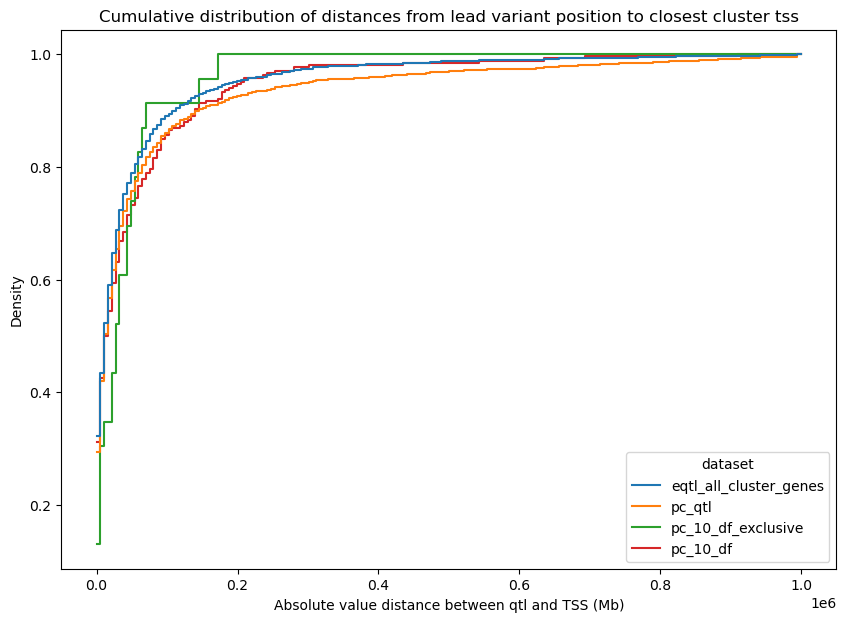

In [103]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
joined['clip_distance'] = joined['distance'].clip(-1000000, 1000000)
# absolute value of distance for that plot
joined['abs_clip_distance'] = joined['clip_distance'].apply(abs)
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='abs_clip_distance', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Absolute value distance between qtl and TSS (Mb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')

### better control group

all eqtls on chr22 as a control

In [41]:
# load in the susie dfs
control_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    control_dfs.append(pd.read_csv(f'{prefix}/output/chr22_eqtl/{tissue_id}/{tissue_id}.v8.chr22_genes.susie.txt', sep='\t', index_col=0))
control_dfs = pd.concat([df.assign(tissue_id=n) for df, n in zip(control_dfs, tissue_ids)])
control_dfs.reset_index(inplace=True, drop=True)
# for debugging, try with a single tissue 

In [42]:
control_dfs['cs_full_id'] = control_dfs['phenotype_id'].astype(str) + '_e_cs' + control_dfs['cs_id'].astype(str) 

def get_lead_var(susie_df):
    return susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')


control_df = pd.DataFrame(pd.Series(control_dfs.groupby(['cs_full_id'])['variant_id'].apply(list), name='variant_list'))
control_df['lead_variant_id'] = get_lead_var(control_dfs)
control_df = control_df.reset_index()
control_df['lead_variant_pos'] = control_df['lead_variant_id'].str.split('_').str[1].astype(int)

In [43]:
def get_control_tss(row):
    egene = row['cs_full_id'].split('_e_')[0]
    gene_df = full_gencode.set_index('transcript_id').loc[egene]
    #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -(row['lead_variant_pos']-gene_df.tss_start)
    else:
        return (row['lead_variant_pos']-gene_df.tss_start)

In [44]:
control_df['tss_distance'] = control_df.progress_apply(get_control_tss, axis=1)
control_df['abs_distance'] = control_df['tss_distance'].apply(abs)

  0%|          | 0/7164 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
control_joined = pd.DataFrame({'distance':control_df['tss_distance'], 'dataset':['all_egene_control']*len(control_df), 'abs_distance':control_df['abs_distance']})
control_joined = pd.concat([joined, control_joined])
control_joined['clip_distance'] = control_joined['distance'].clip(-1000000, 1000000)

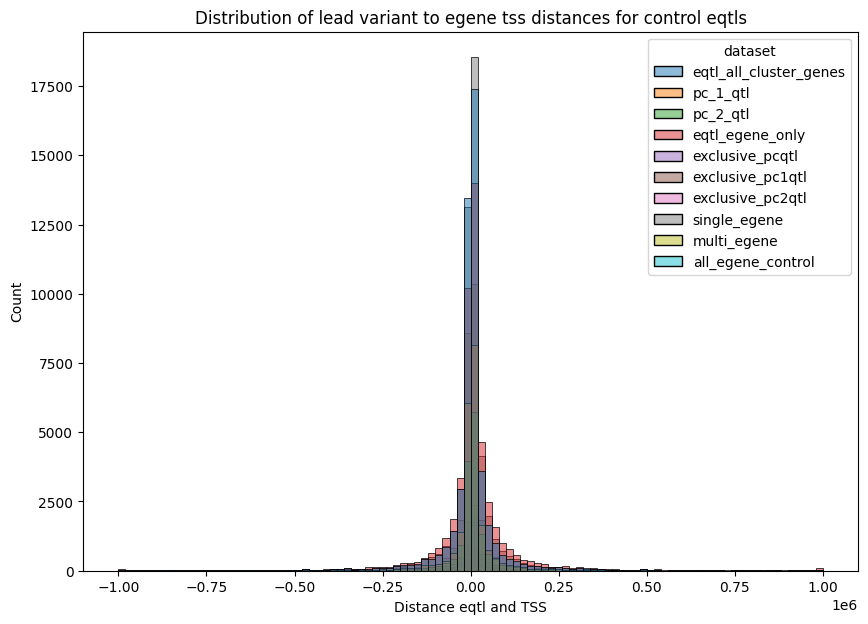

In [ ]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(control_joined, x='clip_distance', bins=100, ax=ax, hue='dataset')
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
plt.show()

Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

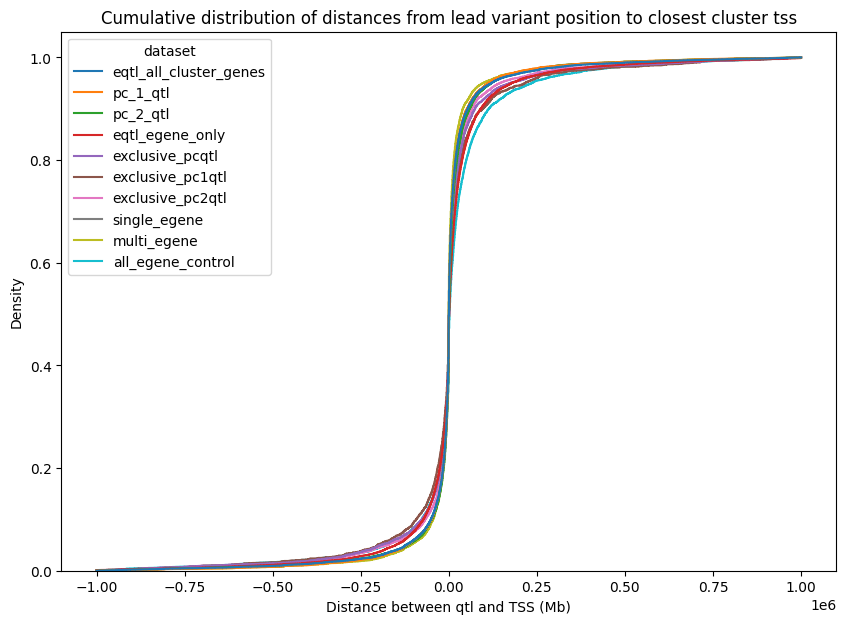

In [ ]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=control_joined, x='clip_distance', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (Mb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')


Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

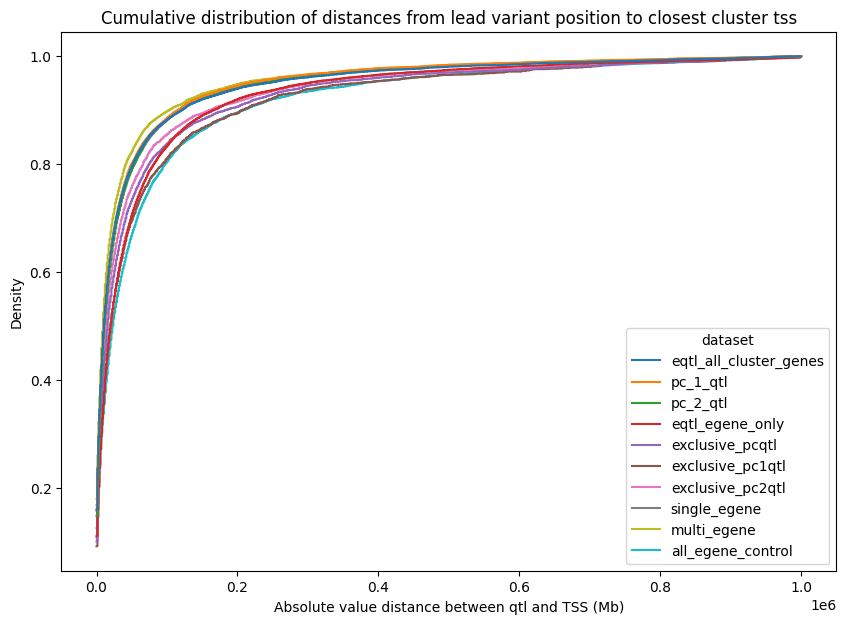

In [ ]:
# absolute value of distance for that plot
control_joined['abs_clip_distance'] = control_joined['clip_distance'].apply(abs)
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=control_joined, x='abs_clip_distance', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Absolute value distance between qtl and TSS (Mb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')


### 250kb bump

There are a bunch of the exclusive pcqtls abount 250kb away
I want to see what's up with these - are they driven by one tissue? or one cluster?

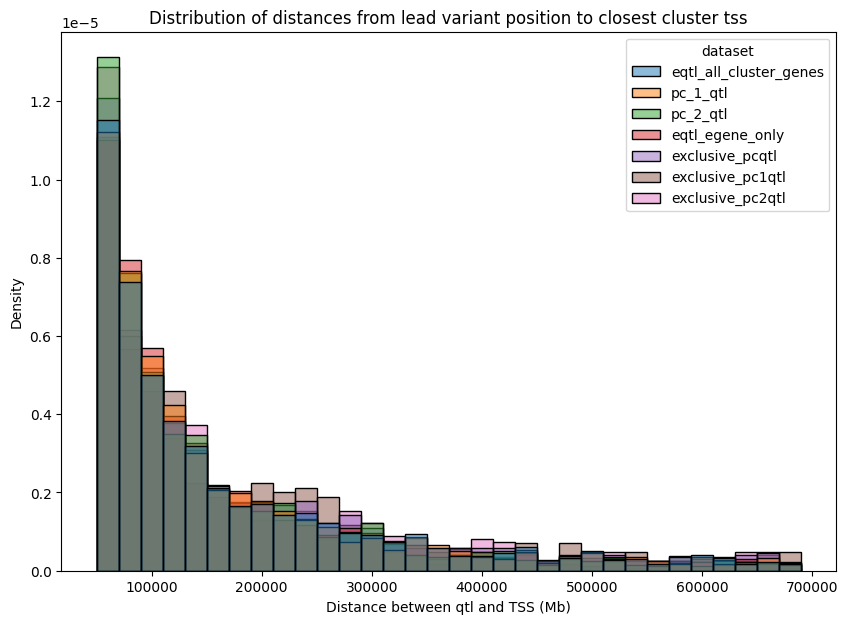

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='clip_distance', hue='dataset', bins=range(50000, 700000, 20000),
            stat='density', ax=ax, common_norm=False)

plt.xlabel('Distance between qtl and TSS (Mb)')
plt.title('Distribution of distances from lead variant position to closest cluster tss')
plt.show()

In [ ]:
bump_df = exclusivepc_df[(exclusivepc_df['cluster_min_distance'] > 200000)&(exclusivepc_df['cluster_min_distance'] < 300000)]
bump_df.head()

,cs_full_id,variant_list,lead_variant_id,cluster_id,orig_cs_dataset,e_samelead,pc1_samelead,pc2_samelead,num_e_samelead,num_pc1_samelead,...,e_overlap_all,pc1_overlap_all,pc2_overlap_all,num_e_overlap_all,num_pc1_overlap_all,num_pc2_overlap_all,tissue_id,lead_variant_pos,cluster_min_distance,num_pc_overlap
4106,ENSG00000064726.9_ENSG00000136404.15_pc1_cs1,"['chr15_82793121_G_A_b38', 'chr15_82795620_A_C...",chr15_82793121_G_A_b38,ENSG00000064726.9_ENSG00000136404.15,pc_1_qtl,[],['ENSG00000064726.9_ENSG00000136404.15_pc1_cs1'],[],0,1,...,[],['ENSG00000064726.9_ENSG00000136404.15_pc1_cs1'],[],0,1,0,Adipose_Subcutaneous,82793121,223301,1
4459,ENSG00000120833.13_ENSG00000246985.7_pc1_cs1,"['chr12_93811430_G_A_b38', 'chr12_93813518_A_G...",chr12_93813518_A_G_b38,ENSG00000120833.13_ENSG00000246985.7,pc_1_qtl,[],['ENSG00000120833.13_ENSG00000246985.7_pc1_cs1'],[],0,1,...,[],['ENSG00000120833.13_ENSG00000246985.7_pc1_cs1'],[],0,1,0,Adipose_Subcutaneous,93813518,243704,1
4646,ENSG00000136108.14_ENSG00000278238.1_pc1_cs2,"['chr13_52253124_A_C_b38', 'chr13_52276733_A_G...",chr13_52678591_A_G_b38,ENSG00000136108.14_ENSG00000278238.1,pc_1_qtl,[],['ENSG00000136108.14_ENSG00000278238.1_pc1_cs2'],[],0,1,...,[],['ENSG00000136108.14_ENSG00000278238.1_pc1_cs2'],[],0,1,0,Adipose_Subcutaneous,52678591,223162,1
5131,ENSG00000172554.11_ENSG00000235688.2_pc1_cs2,"['chr2_714127_C_T_b38', 'chr2_730616_G_T_b38',...",chr2_730616_G_T_b38,ENSG00000172554.11_ENSG00000235688.2,pc_1_qtl,[],['ENSG00000172554.11_ENSG00000235688.2_pc1_cs2'],[],0,1,...,[],['ENSG00000172554.11_ENSG00000235688.2_pc1_cs2'],[],0,1,0,Adipose_Subcutaneous,730616,219011,1
5296,ENSG00000186301.8_ENSG00000215908.10_pc1_cs4,"['chr1_16921023_C_T_b38', 'chr1_16928764_T_C_b...",chr1_16928764_T_C_b38,ENSG00000186301.8_ENSG00000215908.10,pc_1_qtl,[],['ENSG00000186301.8_ENSG00000215908.10_pc1_cs4'],[],0,1,...,[],['ENSG00000235241.1_ENSG00000238142.1_pc1_cs5'...,[],0,2,0,Adipose_Subcutaneous,16928764,283142,1


<Axes: xlabel='tissue_id', ylabel='Count'>

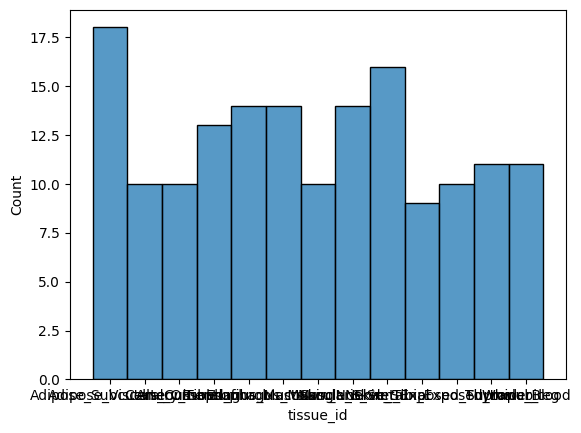

In [ ]:
sns.histplot(bump_df, x='tissue_id')

# end of gene distance

In [ ]:
# distance to whichever gene in the cluster is closest
def get_end_distance(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    ends = cluster_gene_df['gene_end'].values
    distances = row['lead_variant_pos'] - ends
    # return smallest absolute value distance
    idx = np.argmin(abs(distances))
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]

In [ ]:
# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
overlap_df['cluster_end_distance'] = overlap_df.progress_apply(get_end_distance, axis=1)

  0%|          | 0/87867 [00:00<?, ?it/s]

In [ ]:
# add in data for exclusively pc variants
overlap_df['num_pc_overlap'] = overlap_df['num_pc1_overlap'] + overlap_df['num_pc2_overlap']
exclusivepc_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]
e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']
exclusivepc1_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc1_overlap']>0)]
exclusivepc2_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc2_overlap']>0)]
single_egene = overlap_df[(overlap_df['num_e_overlap']==1)]
multi_egene = overlap_df[(overlap_df['num_e_overlap']>1)]

In [ ]:
# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined['end_distance']=np.concatenate([overlap_df['cluster_end_distance'], 
                                                 e_overlap_df['cluster_end_distance'], 
                                                 exclusivepc_df['cluster_end_distance'], 
                                                 exclusivepc1_df['cluster_end_distance'],
                                                 exclusivepc2_df['cluster_end_distance'], 
                                                 single_egene['cluster_end_distance'], 
                                                 multi_egene['cluster_end_distance']])

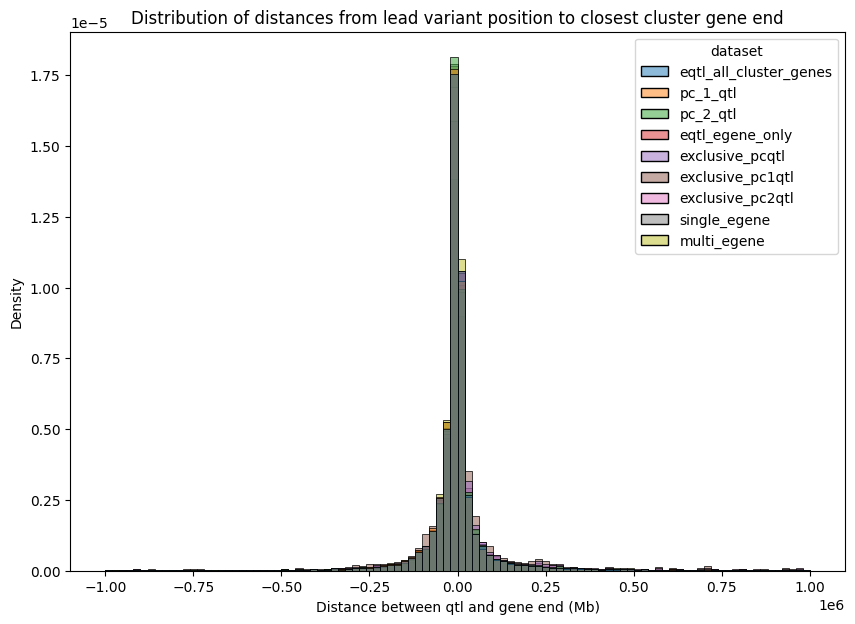

In [ ]:
joined['clip_end_distance'] = joined['end_distance'].clip(-1000000, 1000000)
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='clip_end_distance', hue='dataset', bins=100,
            stat='density', ax=ax, common_norm=False)

plt.xlabel('Distance between qtl and gene end (Mb)')
plt.title('Distribution of distances from lead variant position to closest cluster gene end')
plt.show()